### IMPORTS

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, \
    ConfusionMatrixDisplay
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.utils import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack


### BASELINE
**precision-macro=83.90%
recall-macro=84.75%
f1-macro=84.27%**

--- 

### Logistic Regression
**precision-macro=92.62% 
recall-macro=93.21%
f1-macro=92.9%**

---

### SVM
**precision-macro=94.32%
recall-macro=94.45%
f1-macro=94.38%**

---

### Random Forest
**precision-macro=92.58%
recall-macro=85.04%
f1-macro=87.3%**
****


### LOAD DATASET

In [7]:
X, Y = [], []
with open('a4-data.txt', 'rt', encoding='utf8') as fr:
    lines = fr.read().split('\n')
    for line in lines:
        w, label = line.split('\t')
        X.append(w), Y.append(int(label))
X, Y = np.array(X), np.array(Y)
print(f'total examples: {len(X), X.shape, len(Y), Y.shape}')
print('-' * 50)

total examples: (10336, (10336,), 10336, (10336,))
--------------------------------------------------


### SPLIT DATASET INTO TRAIN/DEV/TEST

In [8]:
# split first into train, test
train_examples, test_examples, train_labels, test_labels = train_test_split(X, Y, train_size=.8, test_size=.2,
                                                                            random_state=1, shuffle=True)

# split the train further into dev
train_examples, dev_examples, train_labels, dev_labels = train_test_split(train_examples, train_labels, train_size=.9,
                                                                          test_size=.1, random_state=1, shuffle=True)

print(f'train examples: {len(train_examples), len(train_labels)}\n'
      f'dev examples: {len(dev_examples), len(dev_labels)}\n'
      f'test examples: {len(test_examples), len(test_labels)}')



train examples: (7441, 7441)
dev examples: (827, 827)
test examples: (2068, 2068)


### Extract Features

In [75]:
def _to_features_(w):
    vowels = [
        "a",
        "e",
        "i",
        "o",
        "u",
        "ä",
        "ö",
        "ü"
    ]
    return [len(w), len([let for let in w if let in vowels])]


def to_features(examples):
    return np.array([_to_features_(w) for w in examples])


vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 3))

train_vectors = vectorizer.fit_transform(train_examples, train_labels)
train_vectors = hstack([train_vectors, to_features(train_examples)])

dev_vectors = vectorizer.transform(dev_examples)
dev_vectors = hstack([dev_vectors, to_features(dev_examples)])

test_vectors = vectorizer.transform(test_examples)
test_vectors = hstack([test_vectors, to_features(test_examples)])

print(train_vectors.shape, dev_vectors.shape, test_vectors.shape)

(7441, 6592) (827, 6592) (2068, 6592)


### INSPECT CLASS DISTRIBUTION (FOR EXAMPLE)
#### I want to see whether the dataset is balanced

In [76]:
labels = np.array(sorted(set(train_labels).union(dev_labels).union(test_labels)))
label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}
print(labels)

train_labels_freq = Counter(train_labels)
dev_labels_freq = Counter(dev_labels)
test_labels_freq = Counter(test_labels)

print(train_labels_freq)

zero_labels = train_labels_freq[0] + dev_labels_freq[0] + test_labels_freq[0]
one_labels = train_labels_freq[1] + dev_labels_freq[1] + test_labels_freq[1]

# class zero is twice more often class
print(zero_labels, one_labels)

print(compute_class_weight(class_weight="balanced", classes=labels, y=Y))

[0 1]
Counter({np.int64(0): 4797, np.int64(1): 2644})
6682 3654
[0.77342113 1.41434045]


### Example Workflow
1. Find the best model to predict the dev data with K-Fold GridSearch
2. Use it on the test data
3. Evaluate the results

### Logistic Regression

In [77]:
grid = GridSearchCV(LogisticRegression(random_state=1, penalty='l2'), param_grid=
{'C': [0.01, 0.05, 0.1, 0.5, 1], 'max_iter': [30, 50, 100, 200], 'class_weight': ['balanced']}, cv=5,
                    scoring='f1_macro')

grid.fit(train_vectors, train_labels)

# you can also directly use best estimator on training data
# best_train_lr = grid.best_estimator_

D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1],
                         'class_weight': ['balanced'],
                         'max_iter': [30, 50, 100, 200]},
             scoring='f1_macro')

In [78]:
# usually we want the best estimator on the dev set to make sure our model generalizes enough

best_lr, best_pr, best_r, bestf1 = None, 0.0, 0.0, 0.0
for param in grid.cv_results_['params']:
    model = LogisticRegression(**param, random_state=1, penalty='l2')
    model.fit(train_vectors, train_labels)
    y_dev_preds = model.predict(dev_vectors)

    # in this case, I choose the model with best f1-macro average 
    f1 = f1_score(dev_labels, y_dev_preds, average='macro')
    if f1 > bestf1:
        bestf1 = f1
        best_pr = precision_score(dev_labels, y_dev_preds, average='macro')
        best_r = recall_score(dev_labels, y_dev_preds, average='macro')
        best_lr = model

# with best model on the dev set    
print(best_lr)
print(f'precision-macro: {round(best_pr, 4) * 100}%\n'
      f'recall-macro: {round(best_r, 4) * 100}%\n'
      f'f1-macro: {round(bestf1, 4) * 100}%')


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

LogisticRegression(C=1, class_weight='balanced', max_iter=50, random_state=1)
precision-macro: 91.4%
recall-macro: 92.31%
f1-macro: 91.83%


In [79]:
# use best model on the test set
y_pred = best_lr.predict(test_vectors)

pmacro, rmacro, f1macro = precision_score(test_labels, y_pred, average='macro'), recall_score(test_labels, y_pred,
                                                                                              average='macro'), f1_score(
    test_labels, y_pred, average='macro')

pmicro, rmicro, f1micro = precision_score(test_labels, y_pred, average='micro'), recall_score(test_labels, y_pred,
                                                                                              average='micro'), f1_score(
    test_labels, y_pred, average='micro')

print(
    f'precision-micro: {round(pmicro, 4) * 100}% recall-micro: {round(rmicro, 4) * 100}% f1-micro: {round(f1micro, 4) * 100}%')
print('-' * 50)
print(
    f'precision-macro: {round(pmacro, 4) * 100}% recall-macro: {round(rmacro, 4) * 100}% f1-macro: {round(f1macro, 4) * 100}%')

precision-micro: 93.42% recall-micro: 93.42% f1-micro: 93.42%
--------------------------------------------------
precision-macro: 92.62% recall-macro: 93.21000000000001% f1-macro: 92.9%


### SVM

In [59]:
grid = GridSearchCV(SVC(random_state=1, kernel='linear'), param_grid={
    'C': [0.01, 0.1, 1],
    'class_weight': ['balanced'],
    'max_iter': [1000, 2000, 3000, 5000]
}, cv=5, scoring='f1_macro')

# gives the best estimator on the train data
grid.fit(train_vectors, train_labels)
best_train_svm = grid.best_estimator_

# with best model on train data
print(best_train_svm, f1_score(dev_labels, best_train_svm.predict(dev_vectors), average='macro'))


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\

SVC(C=1, class_weight='balanced', kernel='linear', max_iter=5000,
    random_state=1) 0.9315215951245364


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [60]:
best_svm, best_pr, best_r, bestf1 = None, 0.0, 0.0, 0.0

for param in grid.cv_results_['params']:
    model = SVC(**param, random_state=1, kernel='linear')
    model.fit(train_vectors, train_labels)
    y_dev_preds = model.predict(dev_vectors)
    f1 = f1_score(dev_labels, y_dev_preds, average='macro')
    if f1 > bestf1:
        bestf1 = f1
        best_pr = precision_score(dev_labels, y_dev_preds, average='macro')
        best_r = recall_score(dev_labels, y_dev_preds, average='macro')
        best_svm = model

# with best model on the dev set    
print(best_svm, bestf1)

D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data w

SVC(C=1, class_weight='balanced', kernel='linear', max_iter=5000,
    random_state=1) 0.9315215951245364


D:\Работен плот\Tubingen\GitHub\SNLP2\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [61]:
# use best model on the test set
y_pred = best_svm.predict(test_vectors)

pmacro, rmacro, f1macro = precision_score(test_labels, y_pred, average='macro'), recall_score(test_labels, y_pred,
                                                                                              average='macro'), f1_score(
    test_labels, y_pred, average='macro')

pmicro, rmicro, f1micro = precision_score(test_labels, y_pred, average='micro'), recall_score(test_labels, y_pred,
                                                                                              average='micro'), f1_score(
    test_labels, y_pred, average='micro')

print(
    f'precision-micro: {round(pmicro, 4) * 100}% recall-micro: {round(rmicro, 4) * 100}% f1-micro: {round(f1micro, 4) * 100}%')
print('-' * 50)
print(
    f'precision-macro: {round(pmacro, 4) * 100}% recall-macro: {round(rmacro, 4) * 100}% f1-macro: {round(f1macro, 4) * 100}%')

precision-micro: 94.83% recall-micro: 94.83% f1-micro: 94.83%
--------------------------------------------------
precision-macro: 94.32000000000001% recall-macro: 94.45% f1-macro: 94.38%


### Random Forest

In [80]:

grid = GridSearchCV(RandomForestClassifier(random_state=1), param_grid={
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [2, 3]
}, cv=5, scoring='f1_macro')

# gives the best estimator on the train data
grid.fit(train_vectors, train_labels)
best_train_rf = grid.best_estimator_

# with best model on train data
print(best_train_rf, f1_score(dev_labels, best_train_rf.predict(dev_vectors), average='macro'))


RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=300, random_state=1) 0.8745203636370283


In [81]:
best_rf, bestf1, best_pr, best_r = None, 0.0, 0.0, 0.0
for param in grid.cv_results_['params']:
    model = RandomForestClassifier(**param, random_state=1)
    model.fit(train_vectors, train_labels)
    y_dev_preds = model.predict(dev_vectors)
    f1 = f1_score(dev_labels, y_dev_preds, average='macro')
    if f1 > bestf1:
        bestf1 = f1
        best_pr = precision_score(dev_labels, y_dev_preds, average='macro')
        best_r = recall_score(dev_labels, y_dev_preds, average='macro')
        best_rf = model

# with best model on the dev set    
print(best_rf, bestf1)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                       random_state=1) 0.8778734924932317


In [82]:
# use best model on the test set
y_pred = best_rf.predict(test_vectors)

pmacro, rmacro, f1macro = precision_score(test_labels, y_pred, average='macro'), recall_score(test_labels, y_pred,
                                                                                              average='macro'), f1_score(
    test_labels, y_pred, average='macro')

pmicro, rmicro, f1micro = precision_score(test_labels, y_pred, average='micro'), recall_score(test_labels, y_pred,
                                                                                              average='micro'), f1_score(
    test_labels, y_pred, average='micro')

print(
    f'precision-micro: {round(pmicro, 4) * 100}% recall-micro: {round(rmicro, 4) * 100}% f1-micro: {round(f1micro, 4) * 100}%')
print('-' * 50)
print(
    f'precision-macro: {round(pmacro, 4) * 100}% recall-macro: {round(rmacro, 4) * 100}% f1-macro: {round(f1macro, 4) * 100}%')

precision-micro: 89.22% recall-micro: 89.22% f1-micro: 89.22%
--------------------------------------------------
precision-macro: 92.58999999999999% recall-macro: 85.04% f1-macro: 87.3%


### BEST-MODEL

In [63]:
print(best_svm)

y_pred = best_svm.predict(test_vectors)
print(classification_report(test_labels, y_pred, labels=labels,
                            target_names=['class 0', 'class 1']))

SVC(C=1, class_weight='balanced', kernel='linear', max_iter=5000,
    random_state=1)
              precision    recall  f1-score   support

     class 0       0.96      0.96      0.96      1327
     class 1       0.92      0.93      0.93       741

    accuracy                           0.95      2068
   macro avg       0.94      0.94      0.94      2068
weighted avg       0.95      0.95      0.95      2068


### Confusion Matrix

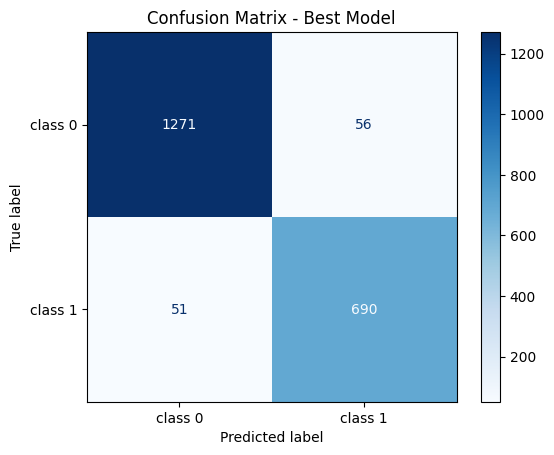

In [74]:
import matplotlib.pyplot as plt

ConfusionMatrixDisplay(confusion_matrix(test_labels, y_pred), display_labels=['class 0', 'class 1']).plot(
    cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best Model')
plt.show()

### Hand-Crafted N-grams

In [47]:
# unigrams, bigrams, trigrams, fourgrams
from collections import defaultdict

unigram2label = defaultdict(lambda: defaultdict(int))
bigram2label = defaultdict(lambda: defaultdict(int))
trigram2label = defaultdict(lambda: defaultdict(int))
fourgram2label = defaultdict(lambda: defaultdict(int))

for idx, w in enumerate(train_examples):
    for i in range(len(w)):
        unigram2label[w[i]][train_labels[idx]] += 1
    for i in range(len(w) - 1):
        bigram2label[(w[i], w[i + 1])][train_labels[idx]] += 1
    for i in range(len(w) - 2):
        trigram2label[(w[i], w[i + 1], w[i + 2])][train_labels[idx]] += 1
    for i in range(len(w) - 3):
        trigram2label[(w[i], w[i + 1], w[i + 2], w[i + 3])][train_labels[idx]] += 1

word2preds = defaultdict(lambda: defaultdict(int))
for idx, w in enumerate(test_examples):
    unigram_prediction = {}
    for i in range(len(w)):
        unigram_d = unigram2label.get(w[i], None)
        if unigram_d:
            unigram_prediction.update(unigram_d)
    if unigram_prediction != {}:
        word2preds[w]['unigram'] = max(unigram_prediction, key=unigram_prediction.get)

    bigram_prediction = {}
    for i in range(len(w) - 1):
        bigram_d = bigram2label.get((w[i], w[i + 1]), None)
        if bigram_d:
            bigram_prediction.update(bigram_d)
    if bigram_prediction != {}:
        word2preds[w]['bigram'] = max(bigram_prediction, key=bigram_prediction.get)

    trigram_prediction = {}
    for i in range(len(w) - 2):
        triram_d = trigram2label.get((w[i], w[i + 1], w[i + 2]), None)
        if triram_d:
            trigram_prediction.update(triram_d)
    if trigram_prediction != {}:
        word2preds[w]['trigram'] = max(trigram_prediction, key=trigram_prediction.get)

    fourgram_prediction = {}
    for i in range(len(w) - 3):
        fourgram_d = fourgram2label.get((w[i], w[i + 1], w[i + 2], w[i + 3]), None)
        if fourgram_d:
            fourgram_prediction.update(fourgram_d)
    if fourgram_prediction != {}:
        word2preds[w]['fourgram'] = max(fourgram_prediction, key=fourgram_prediction.get)

pred = {}
for w in word2preds:
    pred[w] = max(Counter(list(word2preds[w].values())), key=Counter(list(word2preds[w].values())).get)

Y_hat = []
for i in range(len(test_labels)):
    w, label = test_examples[i], test_labels[i]
    y_hat = pred[w]
    Y_hat.append(y_hat)

print(f1_score(test_labels, Y_hat))

0.5705853418593212
